In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import sqlalchemy
import json
import requests
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


In [26]:
#open and read file
df = pd.read_csv("Jobs_NYC_Postings.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [27]:
#Rename FT/PT columns for easier calculations
df =df.rename(columns={'Full-Time/Part-Time indicator': 'FT/PT'})

#Create new column to hold Base Salary Calculations
df['Base Salary'] = 0

#Calculate Daily salary rate to yearly, and copy Annual as yearly
df.loc[df['Salary Frequency'] == 'Daily', 'Base Salary'] = round(df['Salary Range From'].mul(210), 2)
df.loc[df['Salary Frequency'] == 'Annual', 'Base Salary'] = round(df['Salary Range From'], 2)

#calculate Base Salary for Hourly Employees dependent on their FT/PT Status
df['Base Salary'] = np.where((df['FT/PT'] == 'P') & (df['Salary Frequency'] == 'Hourly') , round(df['Salary Range From'].mul(20*52), 2), df['Base Salary'])
df['Base Salary'] = np.where((df['FT/PT'] == 'F') & (df['Salary Frequency'] == 'Hourly') , round(df['Salary Range From'].mul(40*52), 2), df['Base Salary'])

#move Base Salary column to desired location in table
column_to_move = df.pop("Base Salary")  
df.insert(12, "Annual Base Salary", column_to_move) 

/var/folders/f8/zfp3b92j06b3txh4kpfxvwgw0000gn/T/ipykernel_29929/4114675878.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 83932.8   92433.6   99548.4   58653.    63168.    17268.3   78762.6
 100380.    92433.6   83496.    62630.4   17268.3   62630.4   62630.4
  27535.75  17268.3  129830.4   62630.4   58653.    62630.4   62630.4
  17268.3   62630.4   62630.4  100380.    99548.4   83496.    92433.6
  83932.8   17268.3   62630.4   62630.4   83932.8   59152.8   17268.3
 129830.4   78762.6   27535.75  62630.4   59152.8   62630.4   62630.4
  62630.4   63168.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Salary Frequency'] == 'Daily', 'Base Salary'] = round(df['Salary Range From'].mul(210), 2)


In [28]:
#Drop unnecessary columns
df = df.drop(['Title Classification', 'Title Code No', 'Salary Range To', 'Salary Range From', 'Salary Frequency', 'Hours/Shift', 'Post Until', 'Posting Updated', 'Process Date'], axis=1)
df = df.drop(['Preferred Skills', 'Additional Information', 'To Apply', 'Recruitment Contact', 'Work Location 1', 'Job Description'], axis=1)

In [29]:
#rename columns for query managability 
df =df.rename(columns={'FT/PT': 'Ft_Pt', 'Minimum Qual Requirements' : 'Min_qual', 'Job ID' : 'Job_id', '# Of Positions' : 'Num_pos'})
df =df.rename(columns={'Business Title': 'Business_title', 'Civil Service Title' : 'Civil_title', 'Job Category' : 'Category', 'Career Level' : 'Career_level'})
df =df.rename(columns={'Posting Type': 'Posting_type', 'Annual Base Salary' : 'Yearly_salary', 'Work Location' : 'Location', 'Division/Work Unit' : 'Division'})
df =df.rename(columns={'Residency Requirement': 'Res_req', 'Posting Date' : 'Post_Date'})

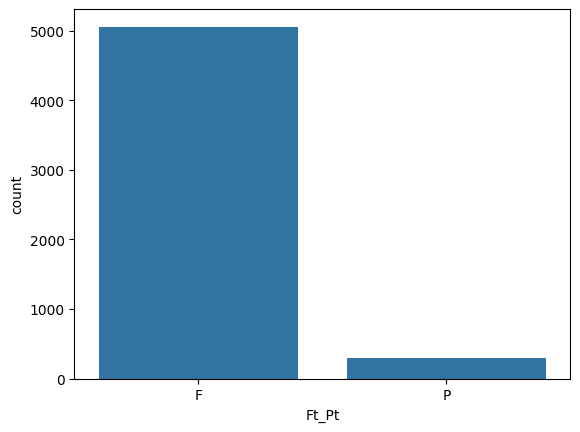

In [31]:
sns.countplot(x='Ft_Pt', data=df)
plt.show()

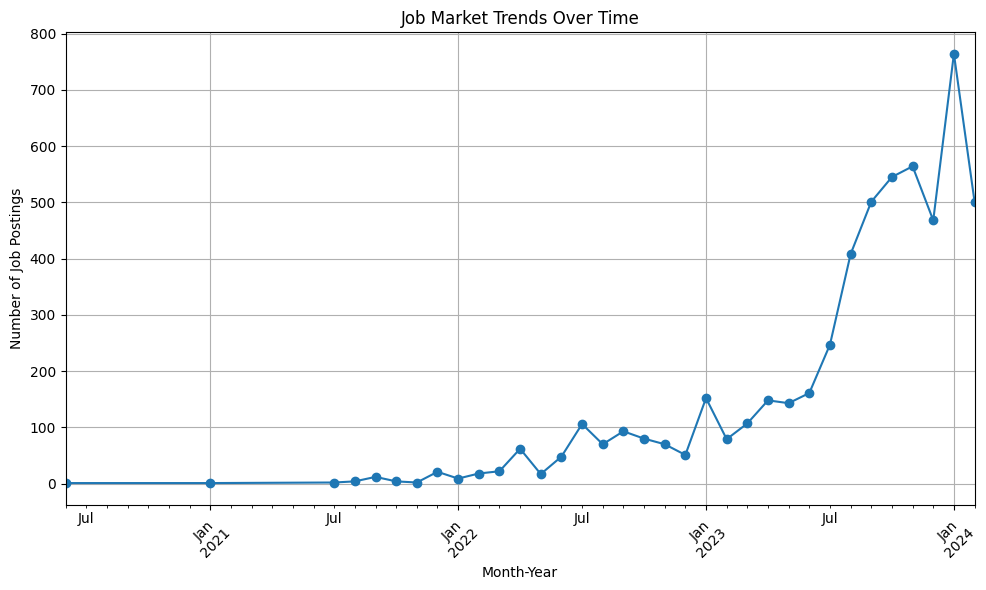

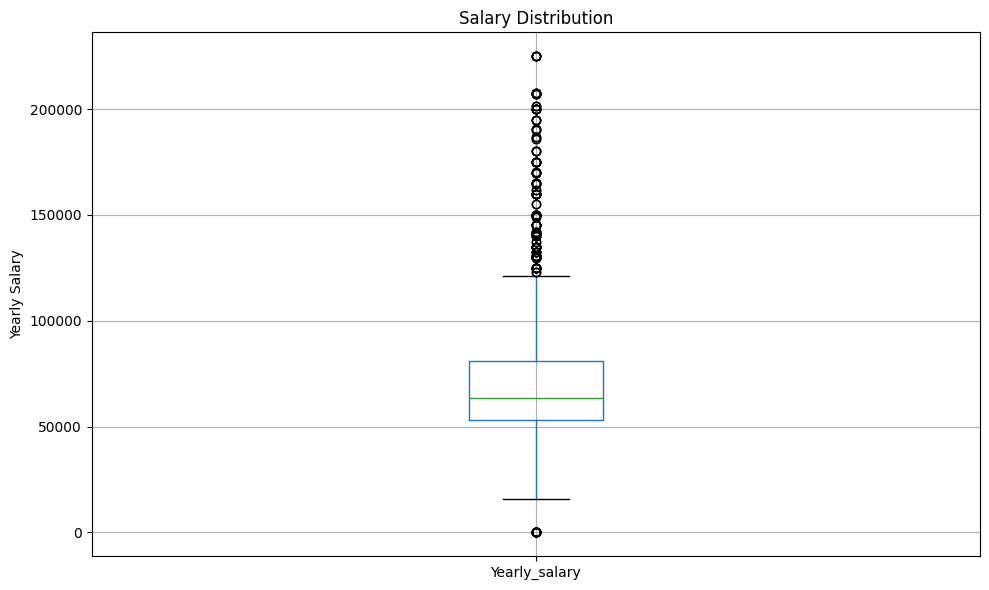

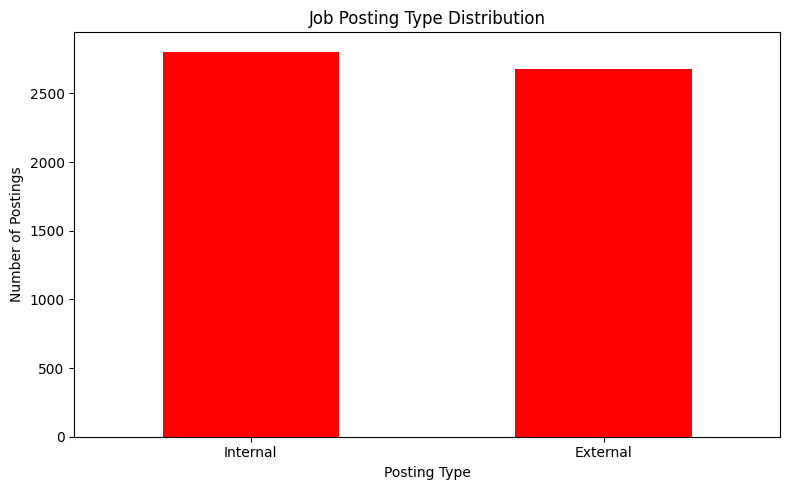

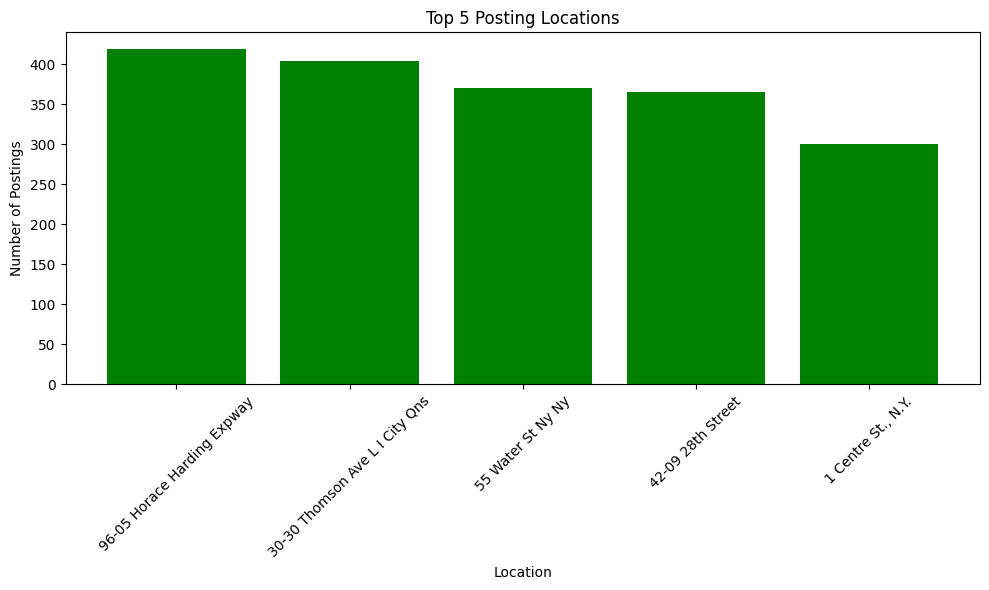

In [40]:


# Job Market Trends Analysis
df['Post_Date'] = pd.to_datetime(df['Post_Date'])
df['month_year'] = df['Post_Date'].dt.to_period('M')
trend_data = df.groupby('month_year').size()

plt.figure(figsize=(10, 6))
trend_data.plot(kind='line', marker='o')
plt.title('Job Market Trends Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Salary Analysis
plt.figure(figsize=(10, 6))
df.boxplot(column='Yearly_salary')
plt.title('Salary Distribution')
plt.ylabel('Yearly Salary')
plt.tight_layout()
plt.show()

# Job Type Analysis
job_type_data = df['Posting_type'].value_counts()

plt.figure(figsize=(8, 5))
job_type_data.plot(kind='bar', color='red')
plt.title('Job Posting Type Distribution')
plt.xlabel('Posting Type')
plt.ylabel('Number of Postings')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Location Analysis
query = """
    SELECT Location, COUNT(*) as num_postings
    FROM NYC_job_postings
    GROUP BY Location
    ORDER BY num_postings DESC
    LIMIT 5
"""

top_locations_df = pd.read_sql(query, con=engine)
plt.figure(figsize=(10, 6))
plt.bar(top_locations_df['Location'], top_locations_df['num_postings'], color='green')
plt.title('Top 5 Posting Locations')
plt.xlabel('Location')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

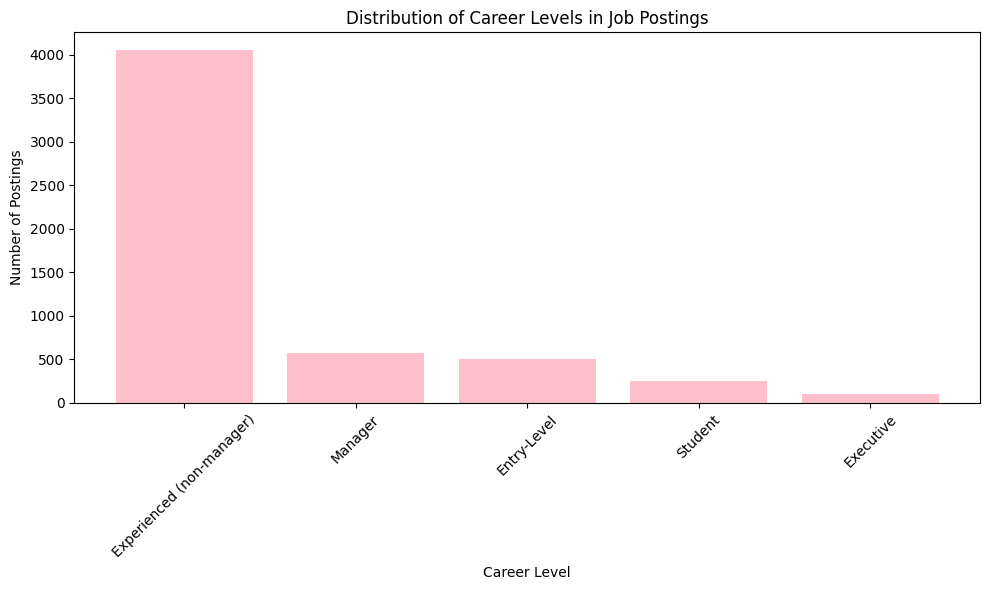

In [43]:
# career level analysis
query = """
    SELECT career_level, COUNT(*) as num_postings
    FROM NYC_job_postings
    GROUP BY career_level
    ORDER BY num_postings DESC
"""


career_level_df = pd.read_sql(query, con=engine)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(career_level_df['Career_level'], career_level_df['num_postings'], color='pink')
plt.title('Distribution of Career Levels in Job Postings')
plt.xlabel('Career Level')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()